# Обучение без подготовки. CLIP

Модели компьтерного зрения в большинстве своём основываются на принципе обучения с учитилем. Встретив объект класса, не представленного в обучающей выборке, модель не сможет его предсказать. Чтобы расширить возможности модели в этом направлении нужно менять архитектуру (как минимум, выходной слой), добавлять необходимые указания в обучающую выборку и переобучать модель.

Допустим, мы столкнулись с задачей классификации изображений, где количество классов не постоянно. Не будем же мы переобучать модель каждый раз когда нужно добавить или убрать очередной класс. А что если использовать для своих задач модель, предобученную на парах (изображение \ текст описания)?

В таком случае эти самые тексты и будут нашими метками классов! Такой подход назвали Zero-shot learning, обучение без обучения/подготовки в русско-язычных источниках, хоть это и не совсем корректно, обучение все же есть.

На помощь нам приходят векторные представления. Если мы можем сопоставить между собой векторное представление изображения и векторное представление текста его описания, то манипулируя с текстом, можем обрабатывать изображения (и наоборот)!

Один из подходов - это технология CLIP от OpenAI.

# CLIP от OpenAI

Основная идея CLIP — создание единого векторного пространства для текстовых и визуальных представлений.

![img](https://hsto.org/getpro/habr/upload_files/f86/9e5/cba/f869e5cbafac1b882a76200c0ef10b3c.png)

Исследователи из OpenAI показали, что обучение на парах изображение-текст — это многообещающая альтернатива "классическим" классификаторам. Задача предобучения заключается в том, чтобы для каждого изображения из пары изображение-текст угадать, какое текстовое описание (`promt`) соответствует именно ему. Модель CLIP (от Contrastive Language-Image Pre-Training), решающую эту задачу, обучали на наборе данных из 400 миллионов пар изображение-описание, собранных из интернета..



Обратите внимание, модель обучалась не на отдельных словах-подписях или метках классов изображений, а именно на целых предложениях-описаниях. Всё для того, чтобы модель находила свзязи между описаниями и самим изображением. В модели CLIP создаются векторные представления для изображений и текстовых описания и эти вектора сопоставляются, сравниваются, между собой. Теперь можно подбирать "лучшие" описания для заданного изображения или наоборот, ранжировать по метрике схожести визуальные и текстовые описания.  

Познакомимся с CLIP поближе и рассмотрим работу на примере.

In [1]:

! pip install ftfy regex tqdm
# CLIP
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.1 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-g8yqbo4u
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-g8yqbo4u
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_

In [2]:
# Для работы с GPU нужной версии
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

CUDA version: 12.2


In [ ]:
#  Ставим Torch с этими версиями и прочие библиотеки
# !pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

In [3]:
import numpy as np
import torch

print("Torch version:", torch.__version__)

assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"

Torch version: 2.2.1+cu121


## Загружаем CLIP

`clip.available_models()` выведет список всех доступных моделей CLIP.

In [4]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

Скачиваем, для примера, ViT-B/32 CLIP, предобученный на 400М пар изображение-текст.  Его можно использовать в режиме `zero-shot learning`.

In [5]:
model, preprocess = clip.load("ViT-B/32") # загружаем
model.cuda().eval() # расчитываем
input_resolution = model.visual.input_resolution # использованное разрешение для изображений
context_length = model.context_length # использованная длина описаний
vocab_size = model.vocab_size # использованный размер словаря описаний

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 61.2MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


## Предобработка изображений

Загруженная модель CLIP представляет из себя Visual Transformer "ViT-B/32", вход модели должен быть фиксированного разрешения  — 224x224 пикселя.

Препроцессинг изображений состоит из изменения размера входного изображения — `Resize` —  и обрезки его по центру — `CenterCrop`. Перед этим нормализуем яркость пикселей картинки, используя поканальное среднее значение из набора данных и стандартное отклонение — `Normalize`. Второе возвращаемое значение метода `.load()` содержит объект `Transform` из библиотеки _torchvision_, который отвечает за описанную выше предобработку.

In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fd1875108b0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Предобработка текста

Для предобработки текста в _Text Transformer_ части сети CLIP используется нечувствительный к регистру токенайзер. Мы не будем углубляться в код, желающие могут полюбопытствовать самостоятельно. Все текстовые описания добиваются до длины `сontext length` (77 в нашем случае).

In [10]:
clip.tokenize("Hello my dear Worsld!")

tensor([[49406,  3306,   607,  3817,   641,    82,   730,   256, 49407,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

In [11]:
clip.tokenize("Hello my dear World!")

tensor([[49406,  3306,   607,  3817,  1002,   256, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

## Подготовка к "обучению"

"Обучим" нашу модель на 8 изображениях и 8 текстах (задача — получить 8 пар изображение-текст, таких, что содержимое этих пар "подходит" друг к другу), а затем построим матрицу косинусных расстояний между векторами изображений и векторами текстов.

In [12]:
import os
import skimage # утилиты для работы с изображениями и несколько картинок
import IPython.display
import matplotlib.pyplot as plt

from PIL import Image
from collections import OrderedDict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Описания для некоторых картинок из skimage, в виде словаря (название картинки: описание)
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse",
    "coffee": "a cup of coffee on a saucer"
}

Загрузим и посмотрим на наши изображения

In [13]:
original_images = []
images = []
texts = []
plt.figure(figsize = (16, 5))
# загружаем картинки
for filename in [filename for filename in
                 os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
    #  рисуем
    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}") # подписываем описания
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])

plt.tight_layout()


Output hidden; open in https://colab.research.google.com to view.

## Получим векторные представления изображений и текстовых описаний

Нормализуем изображения, токенизируем описания, а затем передадим полученные представления в модель. На выходе имеем вектор-представления в общем пространстве визуальных и текстовых представлений.

Описания делаем в виде "This is [описание картинки]"

In [14]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(["This is " + desc for desc in texts]).cuda()

In [15]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float() # вектора картинок
    text_features = model.encode_text(text_tokens).float() # вектора предложений-описаний

## Похожесть векторов по косинусному расстоянию (cosine similarity)

Нормализуем представления и вычислим попарные скалярные произведения - это и будет расчет косинусного расстояния между веторами.

In [16]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Матрица похожести:

Text(0.5, 1.0, 'Cosine similarity between text and image features')

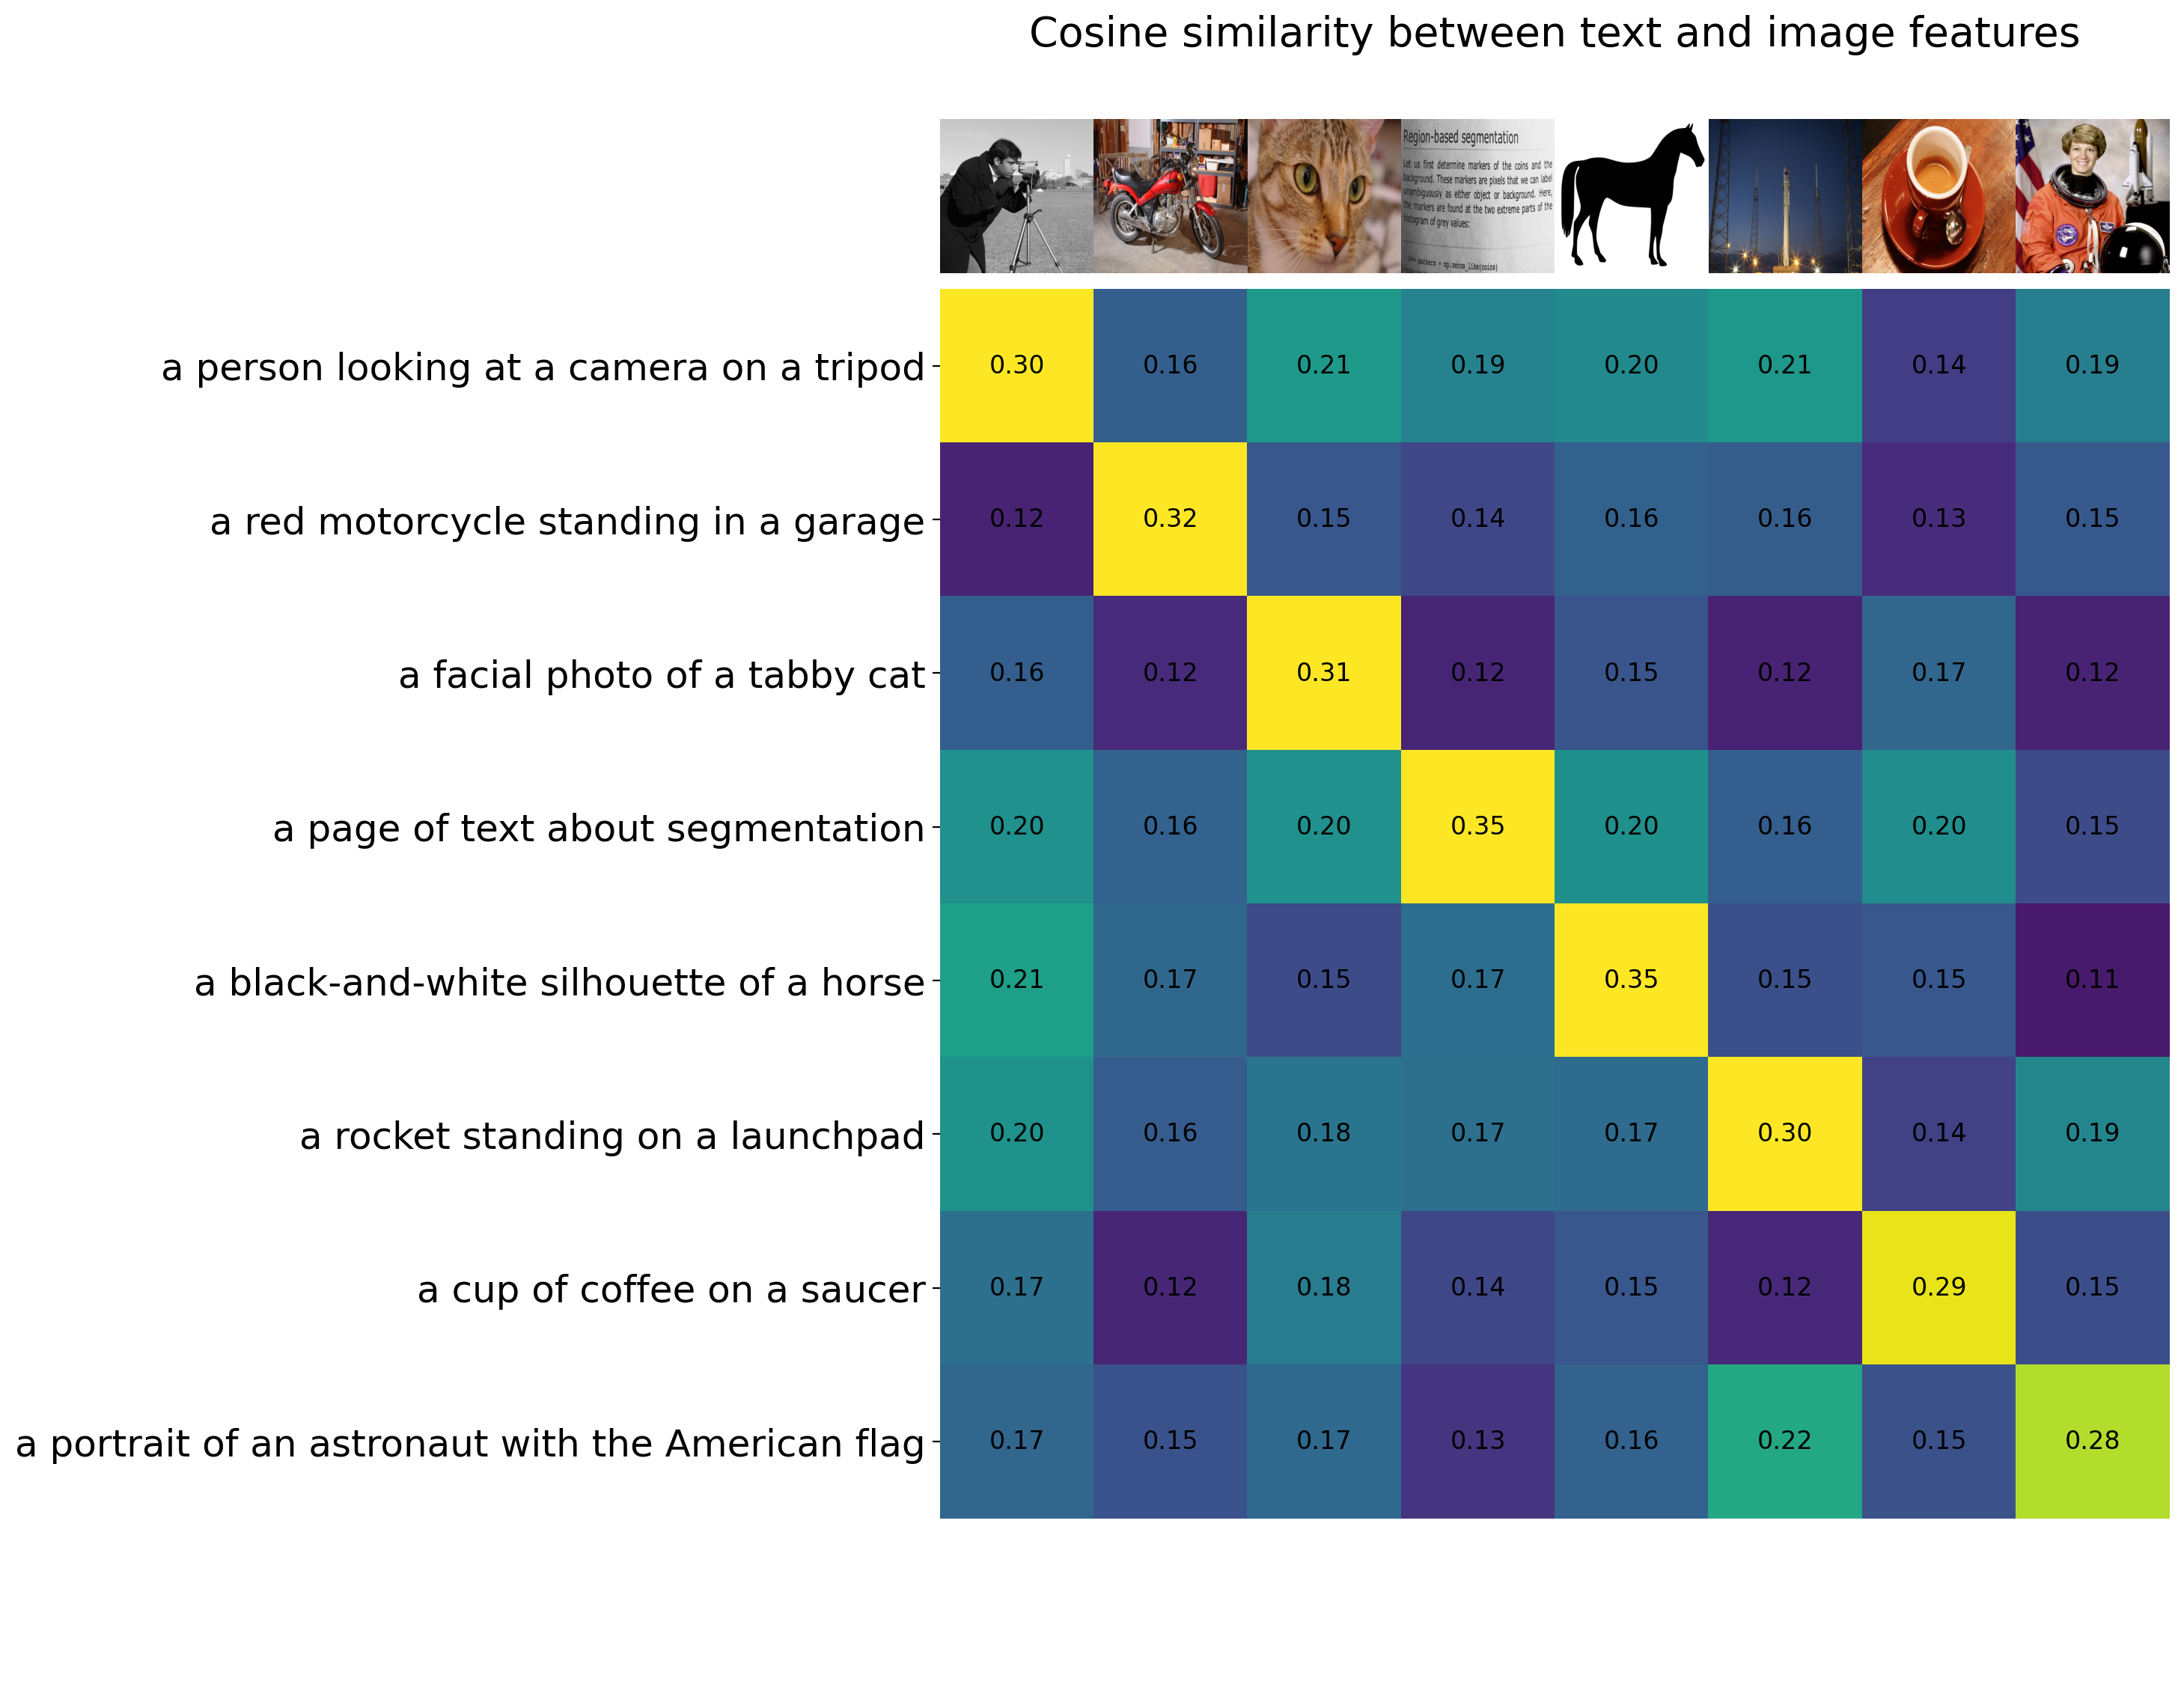

In [17]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), texts, fontsize=18)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

Описания больше всего похожи на картинки, которые они описывают! Удивительно, да? Не идеальная похожесть, но все же она есть.   

## Zero-Shot классификация

Имея возможность считать косинусные расстояния между векторами избражений и текста-описания, можем провести классификацию изображений, выбирая такой текст-описание, который имеет большую степень уверенности (по softmax).

In [18]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform = preprocess, download = True) # какие-то картинки (фотографии)

100%|██████████| 169001437/169001437 [00:06<00:00, 26001393.21it/s]


Extracting /root/.cache/cifar-100-python.tar.gz to /root/.cache


In [19]:
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes] # Истинные классы, записанные в виде предложения
text_tokens = clip.tokenize(text_descriptions).cuda() # токены для них

In [20]:
text_descriptions[0]

'This is a photo of a apple'

In [21]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float() # вектора для текста
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1) # попарное сравнение всех векторов наших изображений и текстов из классов CIFAR
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1) # отбираем 5 самых уверенных

In [22]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace = 0.5)
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Видите и правильно и неправильно распознанные изображения.

# Задание

В ячейке ниже представлены картикни животных. Как видите, они уже разбиты на следующие классы: собаки, кошки, мыши, пингвины, олени, свиньи, лисы, зайцы, волки и львы. Проведите zero-shot классификацию изображений, используя тексты ниже и оцените accuracy классификации.

In [23]:
dog_list = [
        "https://static.wikia.nocookie.net/disney/images/0/06/Profile_-_Lady.jpeg/revision/latest?cb=20190314123153",
        "https://www.artnet.com/WebServices/images/ll00219lld1FRJFg03G72CfDrCWvaHBOcn1GF/walt-disney-studios-a-celluloid-of-tramp-from-lady-and-the-tramp.jpg",
        "https://www.artnet.com/WebServices/images/ll00218lld1FRJFg03G72CfDrCWvaHBOcn1GF/walt-disney-studios-a-celluloid-of-lady-from-lady-and-the-tramp.jpg",
        "https://99px.ru/sstorage/53/2017/09/tmb_208485_1751.jpg",
        "https://mults.info/screen/pes_v_sapogah.jpg",
        "https://i.ytimg.com/vi/cedt81xIj3Q/hqdefault.jpg",
        "https://static.wikia.nocookie.net/adventuretimewithfinnandjake/images/2/2a/Hotdogpeople.png/revision/latest?cb=20120416091001",
        "https://lostpic.net/orig_images/1/f/c/1fca26ebc685f043485c42788815b9f7.png",
        "https://s4.cdn.teleprogramma.pro/wp-content/uploads/2018/03/2715856a35af29d0f8c46bf0ca786e29.jpg",
        "https://img1.looper.com/img/gallery/adventure-time-distant-lands-hints-at-the-death-of-a-fan-favorite-character/intro-1606155312.jpg",
        "https://i.pinimg.com/originals/35/00/f0/3500f0ea8dc332f61a91a5246f43317e.jpg"
        ]

cat_list = [
        "https://cs6.pikabu.ru/images/previews_comm/2015-05_2/1431288516433.jpg",
        "https://citaty.info/files/screenshot_25_0.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR4wFdichLCRxqSw4uJbWpzwxyIopTm6hj7OQ&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR2NV3JGz4zV31iYQhHwVgREcs2Mb6aiE12qA&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS3dAdQaiILpBRX_HvVVHku0WHMzH6K287t5g&usqp=CAU",
        "https://dasound.net/assets/img/people/Matroskin_Kot_19.jpg",
        "https://1.bp.blogspot.com/-Cj98zwDFl-0/Tbiv_tQQ6aI/AAAAAAAAokg/tZnQ8rb1LJ0/s1600/Butch-Cartoon-Photos.jpg",
        "https://i.pinimg.com/originals/d6/74/00/d67400a2fa067bb94e806f8991bc82a9.png",
        "https://topm.3dn.ru/gav1.0-04-13.jpg",
        "https://coub-anubis-a.akamaized.net/coub_storage/coub/simple/cw_timeline_pic/7b51cf5458c/eae8e590cc617e39a9b5b/1473416685_image.jpg",
        "https://ic.pics.livejournal.com/marinagra/32470728/1587945/1587945_original.jpg",
        ]

mice_list = [
        "https://media.tenor.com/images/92dbae244846ba2f79e905c5463cca92/tenor.png",
        "https://mults.info/screen/myszka_08_koncert_swierszcza.jpg",
        "https://img1.goodfon.ru/wallpaper/nbig/3/ad/multfilm-ratatuy-mysh.jpg",
        "https://thumbs.gfycat.com/CheapSmugFlies-poster.jpg",
        "https://www.collegefashion.net/wp-content/uploads/2019/01/steamboat-willie.jpg",
        "https://i.pinimg.com/originals/03/df/6b/03df6b1380d53eff6077638862e6f869.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSh41fJ_QxxghmVRcgrVzktr2tXwGZM7BgJxA&usqp=CAU",
        ]

penguin_list = [
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRcFMVpGddNuiiCl4ilcV5GIAOg8AATAk9joA&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSxXNBxwUGYC5WF_4f648smIslDPBSuup4-7g&usqp=CAU",
        "https://i.ytimg.com/vi/i5aD4FDl9xQ/hqdefault.jpg",
        "https://b1.filmpro.ru/c/280707.700xp.jpg",
        "https://i.mycdn.me/image?id=837524859811&t=50&plc=WEB&tkn=*2l2XEJwKqQSjwuPneOrldOSX4T8&fn=external_8",
        "https://img.gazeta.ru/files3/553/6322553/Penguins-of-Madagascar-2510553-pic700-700x467-20070.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQVVbNdeEafabrihdfBWjRnHwxJ27pe6o6ISQ&usqp=CAU",
        "https://cdnimg.rg.ru/i/gallery/b33a8c9f/7_76035374.jpg",
        ]

deer_list = [
        "https://jewish.ru/culture/cinema/2013/12/bambi.jpg",
        "https://films7.zagonka.tv/uploads/vd/230000/229854/screen_3.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRrLXwwXu1VqSHKz6qFTLeQyNafC4jDVU841w&usqp=CAU",
        "https://i.pinimg.com/originals/84/ea/21/84ea21239cbbb349c86438021efb9f04.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS2FKAmZFflAmF3x7TF4dIlyZttjhDZhs2odw&usqp=CAU",
        ]

pig_list = [
        "https://cs6.pikabu.ru/images/big_size_comm/2015-06_5/1434900465147582999.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSK_kH50T_mJJf42SxYYpqTDq3QBdzDoXazEw&usqp=CAU",
        "https://i.pinimg.com/originals/9d/b3/a4/9db3a479adfd6c9f9073bf239d735f57.jpg",
        "https://www.supercartoons.net/images/cartoons/i-havent-got-a-hat.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTqb-KXeEuK7krA0lspmEtAUHB6FoQaYbGwmQ&usqp=CAU",
        ]

fox_list = [
        "https://russkaja-skazka.ru/wp-content/uploads/2016/08/kolobok-chitat-skazki-s-krasochnyimi-kartinkami-russkaja-skazka-min.jpg",
        "https://s00.yaplakal.com/pics/pics_original/9/7/2/8830279.jpg",
        "https://i.pinimg.com/originals/23/f5/ab/23f5abb963425201a60ae75c649769a5.jpg",
        "https://www.meme-arsenal.com/memes/6a33550feeb673ddc2bfd948a0cf0d4c.jpg",
        ]

bunny_list = [
        "https://slovnet.ru/wp-content/uploads/2019/10/1-56.jpg",
        "https://i.pinimg.com/736x/43/36/3e/43363e92b72ae1a176f4da37a2d98d9c.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZ4vAXbaSboUxHPq36Ti7X01wN1zL5tEquOw&usqp=CAU",
        "https://mult-online.ru/posters/260_347_90_1/uploads/posts/2011-05/thumbs/1305554431_zayac-iz-nu-pogodi.jpg",
        ]

wolf_list = [
        "https://pbs.twimg.com/media/EWug5j5X0AAdquu.jpg:large",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSnrjUbgx0T6qniCkO8m6-6wDmn1rzM2hy0OA&usqp=CAU",
        "https://pobedarf.ru/wp-content/uploads/2020/06/volk.jpg",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQL8WJitB_yODJK06J4vjmRtVFG8iX5Uj-rqg&usqp=CAU",
        ]

lion_list = [
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQYAPtYJJP4qcqJB3duR4-Mnk9at8VGq_Nb4g&usqp=CAU",
        "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRFLJdo3JEE9lY_goArQy0nRBIgZXVefB8c3g&usqp=CAU",
        "https://i.pinimg.com/originals/d5/85/c7/d585c741a26d76d0a0a49a01c1ce33db.jpg",
        "https://i.pinimg.com/originals/1d/d6/e8/1dd6e82e565b95d2c623282d94ec70d7.jpg",
        "https://vdp.mycdn.me/getImage?id=129185155839&idx=11&thumbType=32",
        ]

In [24]:
per_class_lists = [dog_list, cat_list, mice_list, penguin_list, deer_list,
                   pig_list, fox_list, bunny_list, wolf_list, lion_list]

images = []
one_per_class = []

import requests


for per_class_list in per_class_lists:
    for id, url in enumerate(per_class_list):
        try:
            im = Image.open(requests.get(url, stream=True).raw)
            image = preprocess(im)
            if image.shape[0] != 3:
                raise TypeError("Only 3-channel RGB image are allowed")
            images.append(image)
        except:
            print(f"error: {id}, {url}")

error: 7, https://lostpic.net/orig_images/1/f/c/1fca26ebc685f043485c42788815b9f7.png
error: 8, https://s4.cdn.teleprogramma.pro/wp-content/uploads/2018/03/2715856a35af29d0f8c46bf0ca786e29.jpg
error: 9, https://coub-anubis-a.akamaized.net/coub_storage/coub/simple/cw_timeline_pic/7b51cf5458c/eae8e590cc617e39a9b5b/1473416685_image.jpg
error: 3, https://thumbs.gfycat.com/CheapSmugFlies-poster.jpg
error: 5, https://img.gazeta.ru/files3/553/6322553/Penguins-of-Madagascar-2510553-pic700-700x467-20070.jpg
error: 7, https://cdnimg.rg.ru/i/gallery/b33a8c9f/7_76035374.jpg
error: 1, https://films7.zagonka.tv/uploads/vd/230000/229854/screen_3.jpg
error: 3, https://www.supercartoons.net/images/cartoons/i-havent-got-a-hat.jpg
error: 3, https://mult-online.ru/posters/260_347_90_1/uploads/posts/2011-05/thumbs/1305554431_zayac-iz-nu-pogodi.jpg
error: 2, https://pobedarf.ru/wp-content/uploads/2020/06/volk.jpg
error: 4, https://vdp.mycdn.me/getImage?id=129185155839&idx=11&thumbType=32


In [25]:
text_descriptions = ["This is a painting of cartoon dog",
                     "This is a painting of cartoon cat",
                     "This is a painting of cartoon rat or mice",
                     "This is a painting of cartoon penguin",
                     "This is a painting of cartoon deer",
                     "This is a painting of cartoon pig",
                     "This is a painting of cartoon fox",
                     "This is a painting of cartoon hare or bunny",
                     "This is a painting of cartoon wolf",
                     "This is a painting of cartoon lion",]

In [ ]:
# your code here

решение

In [26]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize(text_descriptions).cuda()

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

In [27]:
plt.figure(figsize=(25, 60))

for i, image in enumerate(images):
    plt.subplot(17, 8, 2 * i + 1)
    plt.imshow(image.permute(1, 2, 0))
    plt.axis("off")

    plt.subplot(17, 8, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [text_descriptions[index].split(' ')[-1] for index in top_labels[i].numpy()])
    # plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()